In [ ]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import rerun as rr
import torch
from pytorch3d.io import load_objs_as_meshes
from pytorch3d.renderer import (
    MeshRenderer, MeshRasterizer, FoVPerspectiveCameras,
    RasterizationSettings, look_at_view_transform,
    PointLights
)

import rerun_util as ru

In [2]:
device = torch.device("cuda:0")
meshes = load_objs_as_meshes(['data/cow_mesh/cow.obj'], device=device)

An exception occurred in telemetry logging.Disabling telemetry to prevent further exceptions.
Traceback (most recent call last):
  File "/home/jorge/.conda/envs/texture/lib/python3.10/site-packages/iopath/common/file_io.py", line 946, in __log_tmetry_keys
    handler.log_event()
  File "/home/jorge/.conda/envs/texture/lib/python3.10/site-packages/iopath/common/event_logger.py", line 97, in log_event
    del self._evt
AttributeError: _evt


In [274]:
from pytorch3d.renderer import TexturesUV

verts = meshes.verts_list()[0].cpu()
faces = meshes.faces_list()[0].cpu()
vert_normals = meshes.verts_normals_list()[0].cpu()

textures: TexturesUV = meshes.textures

texture_map = textures.maps_list()[0].cpu()

verts_uvs = textures.verts_uvs_list()[0].cpu()
faces_uvs = textures.faces_uvs_list()[0].cpu()

face_idx = 0
vertex_indices = faces_uvs[face_idx]
uvs = verts_uvs[vertex_indices]

torch.Size([3225, 1024])


ValueError: 'c' argument has 3302400 elements, which is inconsistent with 'x' and 'y' with size 3225.

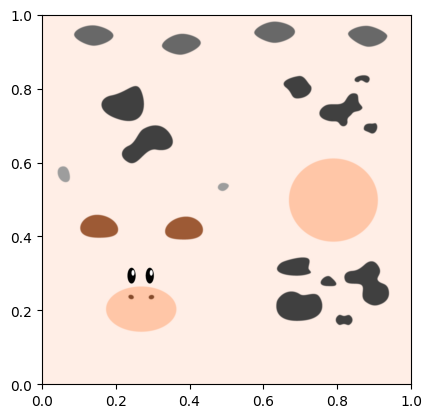

In [273]:


from util import sample_texture, swap_channel_pos

colors = sample_texture(verts_uvs, swap_channel_pos(texture_map))

print(colors.shape)

plt.imshow(texture_map, extent=[0, 1, 0, 1])
plt.scatter(x=verts_uvs[:, 0], y=verts_uvs[:, 1], s=0.4, c=colors * 0.9)

print(texture_map.shape)

In [228]:
rr.init('texture', spawn=True)

rr.log('/', rr.ViewCoordinates.LUF, static=True)
rr.log('mesh', rr.Mesh3D(
    vertex_positions=verts.cpu(),
    triangle_indices=faces.cpu(),
    vertex_normals=vert_normals.cpu(),
    vertex_texcoords=verts_uvs,
    # albedo_texture=texture_map.cpu().numpy(),
))

[2024-08-25T11:24:55Z INFO  re_sdk_comms::server] Hosting a SDK server over TCP at 0.0.0.0:9876. Connect with the Rerun logging SDK.
[2024-08-25T11:24:55Z INFO  winit::platform_impl::platform::x11::window] Guessed window scale factor: 1
[2024-08-25T11:24:56Z WARN  wgpu_hal::gles::adapter] Detected skylake derivative running on mesa i915. Clears to srgb textures will use manual shader clears.
[2024-08-25T11:24:56Z WARN  wgpu_hal::gles::adapter] Detected skylake derivative running on mesa i915. Clears to srgb textures will use manual shader clears.
[2024-08-25T11:24:56Z INFO  egui_wgpu] There were 3 available wgpu adapters: {backend: Vulkan, device_type: DiscreteGpu, name: "NVIDIA RTX A1000 Laptop GPU", driver: "NVIDIA", driver_info: "550.107.02", vendor: 0x10DE, device: 0x25B9}, {backend: Vulkan, device_type: IntegratedGpu, name: "Intel(R) Graphics (ADL GT2)", driver: "Intel open-source Mesa driver", driver_info: "Mesa 24.1.6-arch1.1", vendor: 0x8086, device: 0x4626}, {backend: Gl, devi

In [40]:
from pytorch3d.renderer import SoftSilhouetteShader

torch.no_grad()

# lights
lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

# cameras
dist = 2.5
azim = 150
elev = 0
R, T = look_at_view_transform(dist=dist, azim=azim, elev=elev)

cameras = FoVPerspectiveCameras(device=device, R=R, T=T, fov=60)

ru.pt3d_FovCamera(cameras)

# raster settings
raster_settings = RasterizationSettings(
    image_size=512,
    blur_radius=0.0,
    faces_per_pixel=1,
)

rasterizer = MeshRasterizer(cameras=cameras, raster_settings=raster_settings)
shader = SoftSilhouetteShader()

renderer = MeshRenderer(rasterizer=rasterizer, shader=shader)

renders = renderer(meshes, cameras=cameras)
fragments = rasterizer(meshes)

render = renders.cpu()
depth = fragments.zbuf.cpu()

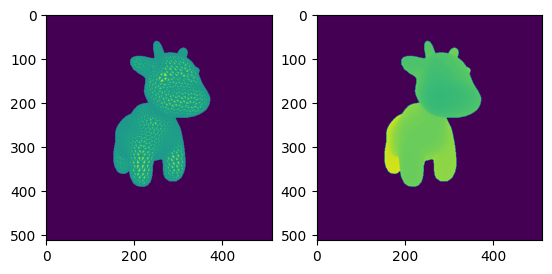

In [41]:
import matplotlib.pyplot as plt

torch.save(depth, 'data/depth.pt')
torch.save(render, 'data/render.pt')

fig, (ax_d, ax_r) = plt.subplots(1, 2)

ax_d.imshow(render[0, :, :, 3])
ax_r.imshow(depth[0])
plt.show()

In [46]:
# VISUALIZATION:
rr.init(spawn=True, application_id='meshvis')

rr.log('/', rr.ViewCoordinates.LUF, static=True)
rr.log('/', rr.Transform3D())

# log mesh
rr.log("mesh", ru.pt3d_mesh(meshes))

# log camera
rr.log('cam', ru.pt3d_FovCamera(cameras))
cam_trans = cameras.get_world_to_view_transform().inverse()
rr.log('cam', ru.pt3d_transform(cam_trans))

print(depth.shape)
# log depth
rr.log('cam', rr.Image(depth[0].numpy()))

torch.Size([1, 512, 512, 1])


[2024-08-25T10:21:31Z INFO  re_sdk_comms::server] Hosting a SDK server over TCP at 0.0.0.0:9876. Connect with the Rerun logging SDK.
[2024-08-25T10:21:31Z INFO  winit::platform_impl::platform::x11::window] Guessed window scale factor: 1
[2024-08-25T10:21:31Z INFO  re_sdk_comms::server] New SDK client connected from: 127.0.0.1:36970
[2024-08-25T10:21:31Z WARN  wgpu_hal::gles::adapter] Detected skylake derivative running on mesa i915. Clears to srgb textures will use manual shader clears.
